In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ,get_json_from_file

Gtk-Message: 19:41:24.852: Failed to load module "canberra-gtk-module"


In [2]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

19:41:32: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:41:32: Debug: Adding duplicate animation handler for '1' type
19:41:32: Debug: Adding duplicate animation handler for '2' type
19:41:32: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:41:32: Debug: Adding duplicate animation handler for '1' type
19:41:32: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:3594): Gtk-CRITICAL **: 19:41:33.291: gtk_window_resize: assertion 'height > 0' failed


In [3]:
# Variables
dataset_id = "ds000171"
bids_root = "./ds000171"  # Directory to store the downloaded dataset
# Path to the 'derivatives' directory for processed data
deriv_root = os.path.join(bids_root, 'derivatives')

# Create a directory for preprocessed data (e.g., 'preprocessed_data')
preproc_root = os.path.join(deriv_root, 'preprocessed_data')

# Create the target directory if it does not exist
if not os.path.exists(bids_root):
    os.makedirs(bids_root)

if not os.path.exists(preproc_root):
    os.makedirs(preproc_root)

subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-con')]
# Loop over all subjects and create directories for each subject's processed data
for subject in subjects:
    subject_dir = os.path.join(preproc_root, subject)

    # Create subdirectories for anatomical and functional data
    os.makedirs(os.path.join(subject_dir, 'anat'), exist_ok=True)
    os.makedirs(os.path.join(subject_dir, 'func'), exist_ok=True)

print(f"Directories created for processed data in {preproc_root}")
subject_01 = 'sub-control01'

Directories created for processed data in ./ds000171/derivatives/preprocessed_data


In [4]:
def list_nii_gz_files(folder_path):
    """ 
    Return a list with all the nii.gz files in the pointed directory
    """    
    
    files = glob.glob(os.path.join(folder_path, '*.nii.gz'))
    file_names = [os.path.basename(file) for file in files]
    return file_names

folder_path = "ds000171/sub-control01/func/"
func_list = list_nii_gz_files(folder_path)
len(func_list)

5

In [5]:
fsleyesDisplay.resetOverlays()
test_display = op.join(bids_root, subject_01, "func" ,func_list[1])
fsleyesDisplay.load(test_display)


(ipykernel_launcher.py:3594): Gdk-WARNING **: 19:41:43.365: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [6]:
func_list

['sub-control01_task-music_run-1_bold.nii.gz',
 'sub-control01_task-nonmusic_run-5_bold.nii.gz',
 'sub-control01_task-music_run-3_bold.nii.gz',
 'sub-control01_task-music_run-2_bold.nii.gz',
 'sub-control01_task-nonmusic_run-4_bold.nii.gz']

In [7]:
# SLICE -TIMING ON INDIVIDUAL RUNS

from tqdm import tqdm

# slice acquired on z axis
data = get_json_from_file("ds000171/task-music_bold.json")
slice_timing = data['SliceTiming']
tr = data['RepetitionTime'] 
slice_order = np.argsort(slice_timing) + 1

# Write to a file the corresponding sorted timings :)
timing_path = op.join(preproc_root,  subject_01, 'func', 'run-01_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order:
    file.write(str(t) + '\n')
file.close()

slice_corr_epi_path = []
for n,f in tqdm(enumerate(func_list)) :
    file_to_realign =  op.join("ds000171/sub-control01/func",f)
    output_target = op.join(preproc_root,"sub-control01/func/sub01_run{}_slice-corr.nii.gz".format(n+1))
    slice_corr_epi_path.append(output_target)
    subprocess.run(['slicetimer', '-i', file_to_realign, '-o', output_target, '-r', str(tr), '-d', str(3), '--ocustom={}'.format(timing_path)])
    #cmd = 'slicetimer -i ' + file_to_realign + ' -o ' + output_target + ' -r ' + str(tr) + ' -d 3 --ocustom=' + timing_path
    #os.system(cmd)
print("Slice-Correction Done")

5it [01:07, 13.56s/it]

Slice-Correction Done


In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(file_to_realign)
fsleyesDisplay.load(output_target)


In [9]:
slice_corr_epi_path

['./ds000171/derivatives/preprocessed_data/sub-control01/func/sub01_run1_slice-corr.nii.gz',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub01_run2_slice-corr.nii.gz',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub01_run3_slice-corr.nii.gz',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub01_run4_slice-corr.nii.gz',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub01_run5_slice-corr.nii.gz']

In [10]:
std_epi_path = []
for n,f in enumerate(slice_corr_epi_path) : 
    niigz_file = f
    img = nib.load(niigz_file)
    data = img.get_fdata()  
    standardized_data = np.zeros_like(data)  
    
    for t in range(data.shape[3]):
        volume = data[:, :, :, t]  
        mean = np.mean(volume)
        std = np.std(volume)
        if std != 0:  
            standardized_data[:, :, :, t] = (volume - mean) / std
        else:
            print("Warning std = 0 | volume {} will remove unchanged".format(t))
            standardized_data[:, :, :, t] = volume  
    
    standardized_img = nib.Nifti1Image(standardized_data, img.affine, img.header)
    
    output_file = 'sub01_run{}_slice-corr_std.nii.gz'.format(n + 1)
    nib.save(standardized_img, op.join(preproc_root, subject_01, "func", output_file))
    std_epi_path.append(op.join(preproc_root, subject_01, "func", output_file))
    print(f"Standardized data saved to {output_file}")


Standardized data saved to sub01_run1_slice-corr_std.nii.gz
Standardized data saved to sub01_run2_slice-corr_std.nii.gz
Standardized data saved to sub01_run3_slice-corr_std.nii.gz
Standardized data saved to sub01_run4_slice-corr_std.nii.gz
Standardized data saved to sub01_run5_slice-corr_std.nii.gz


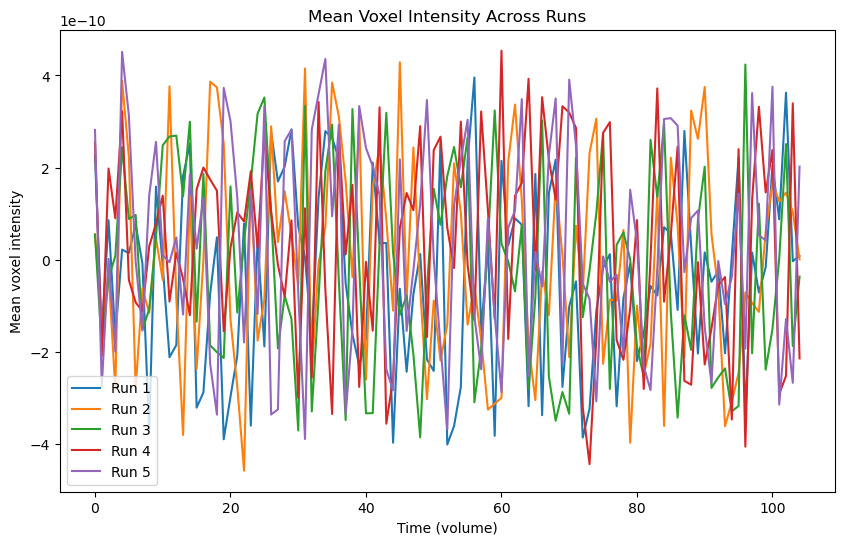

In [11]:
import matplotlib.pyplot as plt
import nibabel as nib


plt.figure(figsize=(10, 6))
for i, file_path in enumerate(std_epi_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    mean_intensity = data.mean(axis=(0, 1, 2))
    plt.plot(mean_intensity, label=f"Run {i+1}")
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
plt.title('Mean Voxel Intensity Across Runs')
plt.legend()
plt.show()


In [12]:
data = []
for file_path in std_epi_path:
    nii = nib.load(file_path)
    data.append(nii.get_fdata())

# Concatenate the data arrays along the 4th dimension
concatenated_data = np.concatenate(data, axis=3)

# Create a new NIfTI image
concatenated_img = nib.Nifti1Image(concatenated_data, nii.affine)

concat_runs_path = op.join(preproc_root, subject_01, 'func','concat_run_slice-corr_std.nii.gz')
nib.save(concatenated_img, concat_runs_path)

In [13]:
# MOTION CORRECTION ON CONCATANATED RUNS
from fsl.wrappers import mcflirt

concat_runs_moco = os.path.join(preproc_root, subject_01, 'func','concat_run_std_moco.nii.gz')
mcflirt(infile= concat_runs_path,o=concat_runs_moco, plots=True, report=True, dof=6, mats=True)
print("Motion Correction Done")

Processed data will be saved as ./ds000171/derivatives/preprocessed_data/sub-control01/func/concat_run_std_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [262] to 8 mm pixels
Registering volumes ... [263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402

refnum = 262
Original_refvol = -1


Registering volumes ... [263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][

Motion Correction Done


In [14]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(concat_runs_moco)
#fsleyesDisplay.load(concat_runs_path)

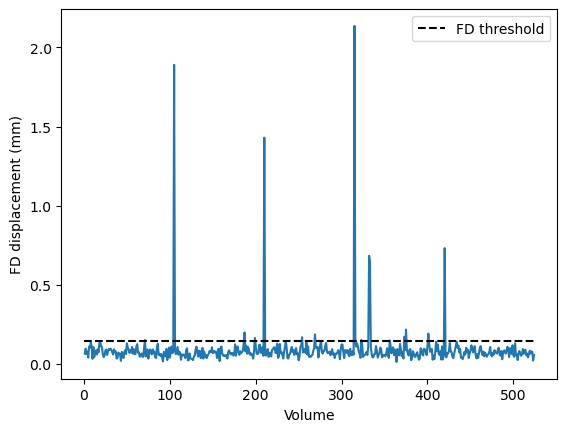

In [15]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(os.path.join(preproc_root, subject_01, 'func','concat_run_std_moco.nii.gz.par'))

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 525,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [16]:
outliers_volumes = np.where(fd > threshold)[0] + 1
outliers_volumes 

array([ 71, 105, 187, 199, 210, 254, 269, 315, 323, 332, 333, 356, 373,
       375, 401, 420])

In [17]:
# SMOOTHING ON CONCATANETED RUN

input_path = concat_runs_moco
output_path = op.join(preproc_root, subject_01, 'func','concat_run_std_moco_10mm_smooth.nii.gz')
cmd = ['fslmaths',input_path,'-s', str(10 / 2.3548), output_path]    
subprocess.run(cmd)
print("Smoothing completed. Smoothed 4D volume saved at:", output_path)

Smoothing completed. Smoothed 4D volume saved at: ./ds000171/derivatives/preprocessed_data/sub-control01/func/concat_run_std_moco_10mm_smooth.nii.gz


In [18]:
fsleyesDisplay.load(output_path)

In [3]:
import pandas as pd
import os.path as op

#ON PEUT RERUN DEPUIS ICI si le kernel crash pour le GLM !!!!


tsv_file_path = "ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv"
table_of_times= pd.read_csv(tsv_file_path, sep='\t')
def concatenate_with_adjusted_onset(df, times):
    concatenated_data = []
    max_onset = 0

    for _ in range(times):

        df_copy = df.copy()
        df_copy['onset'] += max_onset
        concatenated_data.append(df_copy)

        max_onset = df_copy['onset'].max() + 3
    result = pd.concat(concatenated_data, ignore_index=True)

    return result, concatenated_data


In [4]:
concatenated_table, event_list= concatenate_with_adjusted_onset(table_of_times, 5)
#image = output_path
preproc_root = "ds000171/derivatives/preprocessed_data"
subject_01 = "sub-control01"
image = op.join(preproc_root, subject_01, 'func','concat_run_std_moco_10mm_smooth.nii.gz')
#image = nib.load(image)

In [5]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(image,concatenated_table)

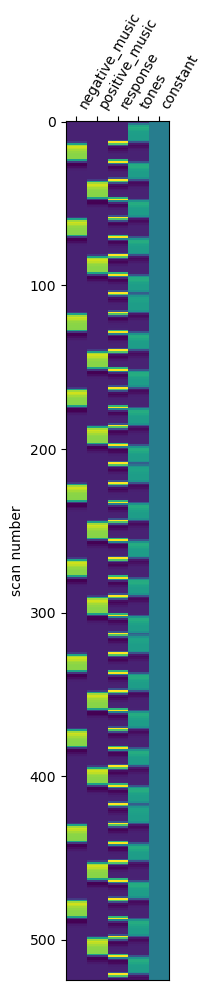

In [6]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [49]:
import numpy as np

conditions = {
    'negative': np.array([1, 0, 0, 0, 0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'positive':np.array([0, 1, 0, 0, 0]),
    'reponse':np.array([0, 0, 1, 0, 0]),
    'tones':np.array([0, 0, 0, 1, 0])
}

# SET THRESHOLD FOR ALL THE FOLLOWING STATISTICAL MAPS
set_threshold = 2

positive_minus_negative = conditions['positive'] - conditions['negative']
positive_minus_negative


array([-1,  1,  0,  0,  0])

<Axes: label='conditions'>

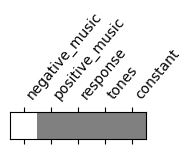

In [50]:
from nilearn.plotting import plot_contrast_matrix
##plot_contrast_matrix(positive_minus_negative, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE

#### Statistical map for each regressor ?
plot_contrast_matrix(conditions['negative'], design_matrix=fmri_glm.design_matrices_[0])  

In [51]:
#### Statistical map for NEGATIVE ?

import nibabel as nib
z_map_neg = fmri_glm.compute_contrast(conditions['negative'],
                                  output_type='z_score')

nib.save(z_map, 'z_map_neg_uncorrected.nii.gz')

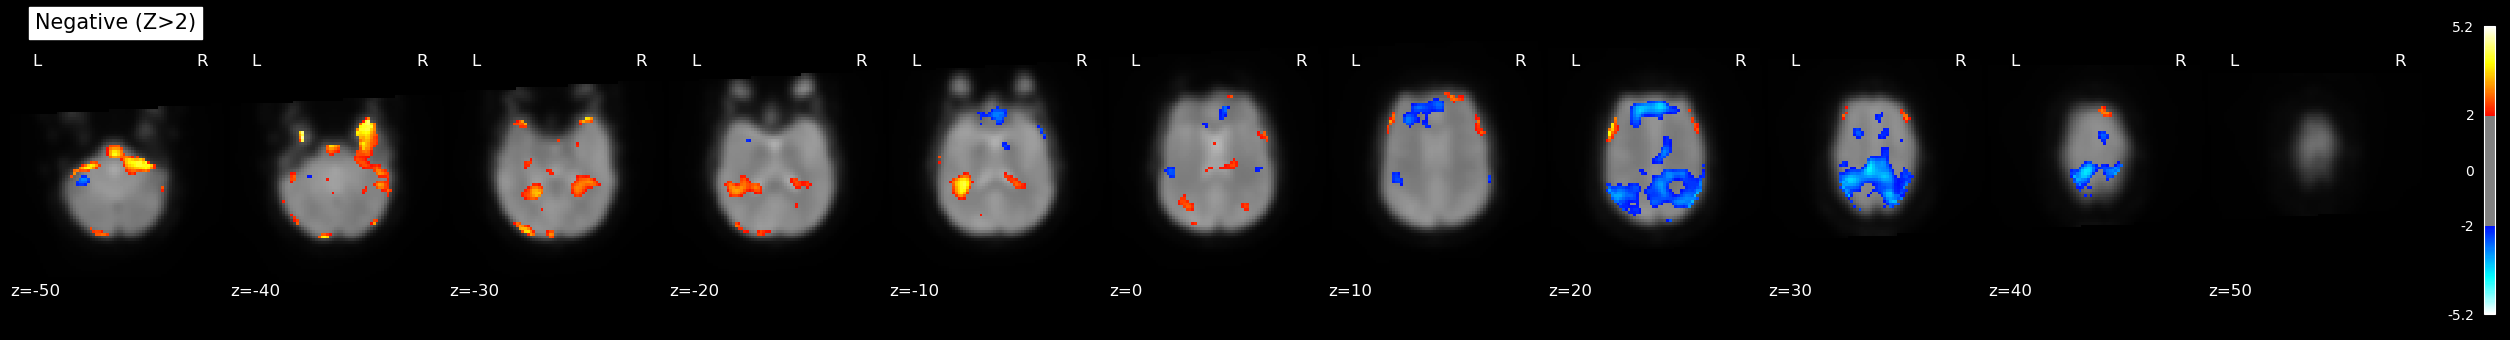

In [48]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img

mean_img_ = mean_img(image), # est ce que ça pourrait engendrer des trucs ici ?
plot_stat_map(z_map_neg, bg_img=mean_img_[0], threshold=set_threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Negative (Z>{set_threshold})')
plt.show()

<Axes: label='conditions'>

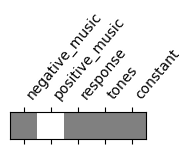

In [41]:
#### Statistical map for POSITIVE ?

import nibabel as nib
z_map_pos = fmri_glm.compute_contrast(conditions['positive'],
                                  output_type='z_score')

nib.save(z_map, 'z_map_pos_uncorrected.nii.gz')

plot_contrast_matrix(conditions['positive'], design_matrix=fmri_glm.design_matrices_[0])  

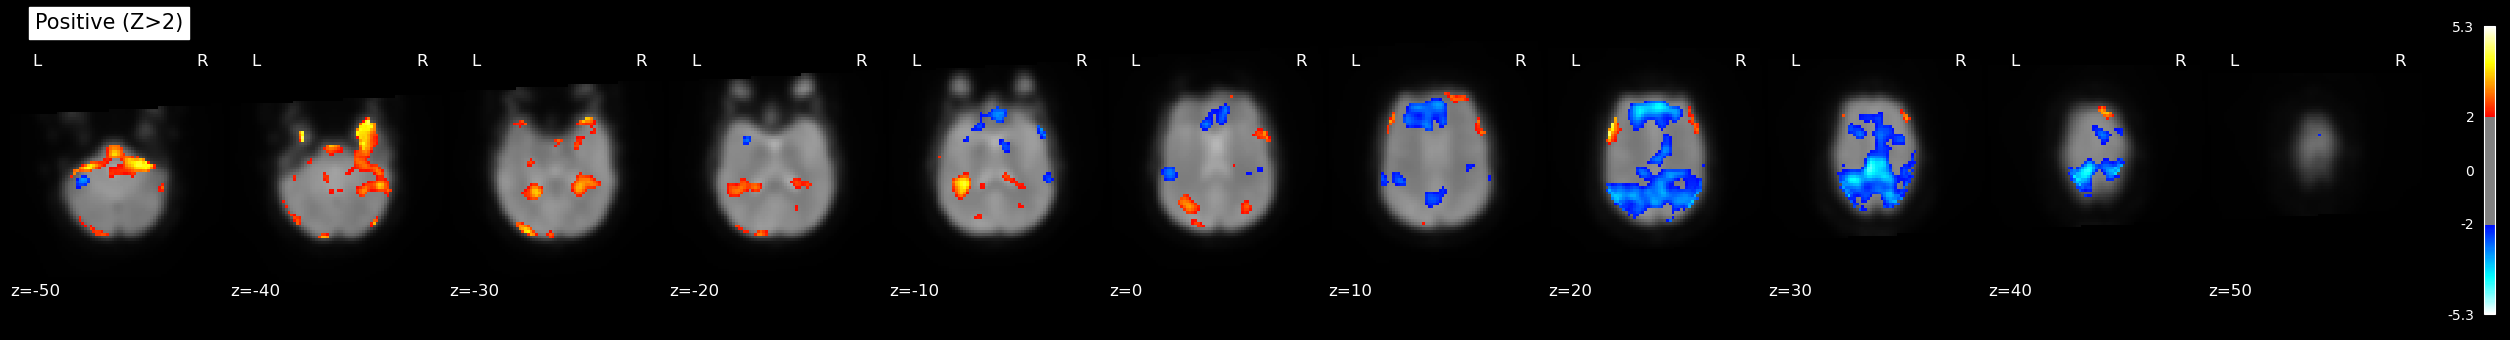

In [72]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(image), # est ce que ça pourrait engendrer des trucs ici ?
plot_stat_map(z_map_pos, bg_img=mean_img_[0], threshold=set_threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Positive (Z>{set_threshold})')
plt.show()

<Axes: label='conditions'>

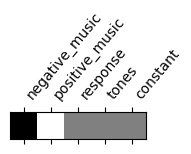

In [43]:
#### Statistical map for POSITIVE AGAINST NEGATIVE ?

import nibabel as nib
z_map_soustraction = fmri_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_soustraction_uncorrected.nii.gz')

plot_contrast_matrix(positive_minus_negative, design_matrix=fmri_glm.design_matrices_[0])  


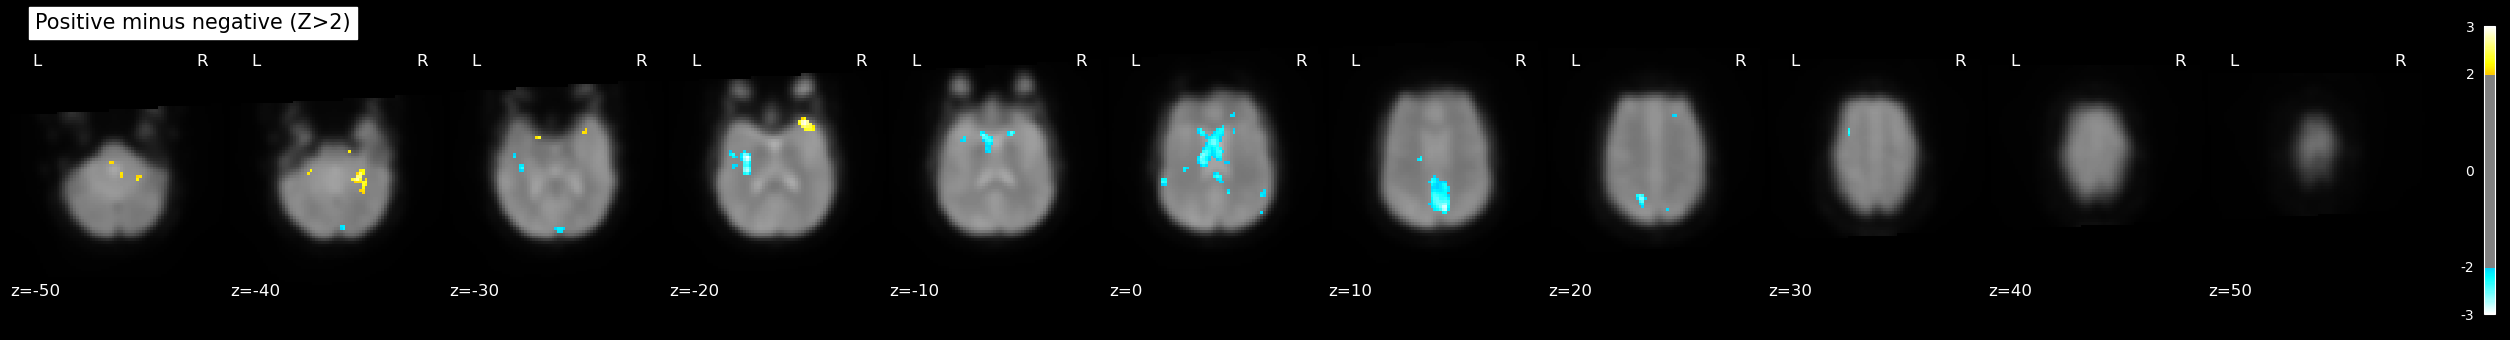

In [71]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(image), # est ce que ça pourrait engendrer des trucs ici ?
plot_stat_map(z_map_soustraction, bg_img=mean_img_[0], threshold=set_threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Positive minus negative (Z>{set_threshold})')
plt.savefig('images_rapport/p_minus_n_.png', format='png', dpi =300)
plt.show()

<Axes: label='conditions'>

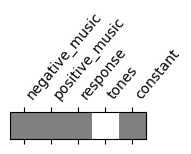

In [45]:
#### Statistical map for TONES ?

import nibabel as nib
z_map_tones = fmri_glm.compute_contrast(conditions['tones'],
                                  output_type='z_score')

nib.save(z_map, 'z_map_tones_uncorrected.nii.gz')

plot_contrast_matrix(conditions['tones'], design_matrix=fmri_glm.design_matrices_[0])  

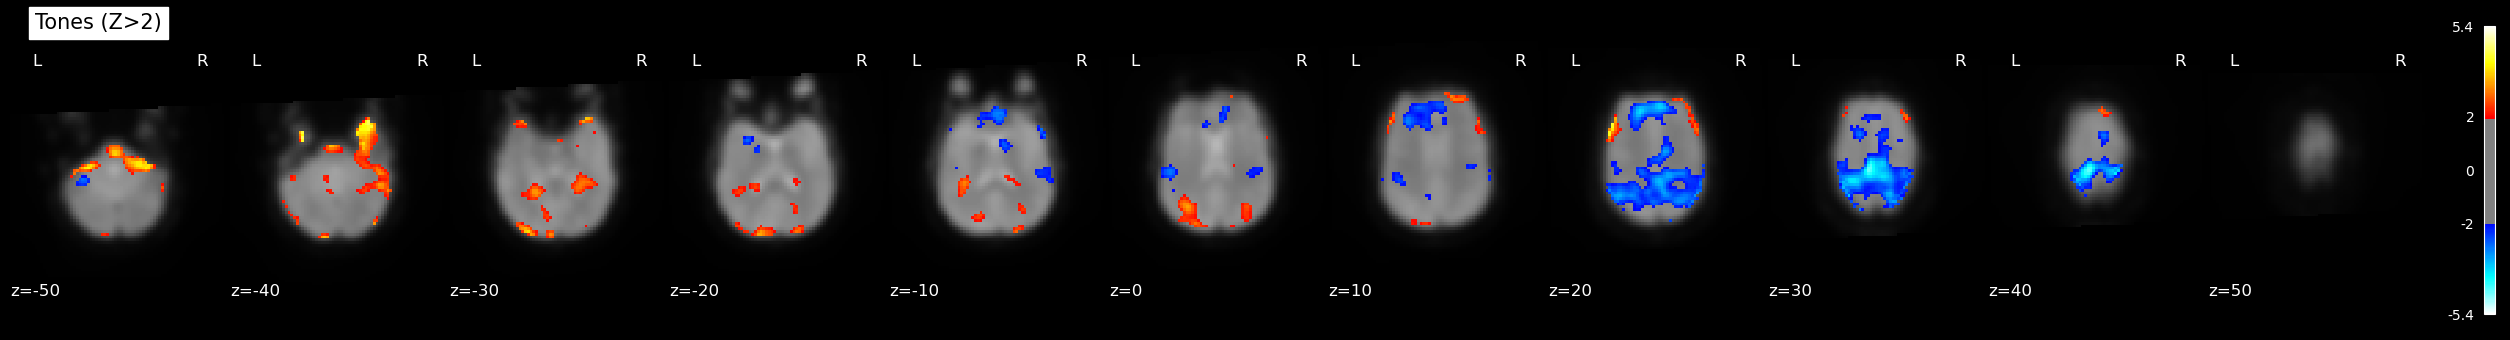

In [52]:
from nilearn.plotting import plot_stat_map 
from nilearn.image import mean_img
mean_img_ = mean_img(image), # est ce que ça pourrait engendrer des trucs ici ?
plot_stat_map(z_map_tones, bg_img=mean_img_[0], threshold=set_threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Tones (Z>{set_threshold})')
plt.show()

/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.664052879395936. But, you have given threshold=inf.
  stat_img = threshold_img(
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


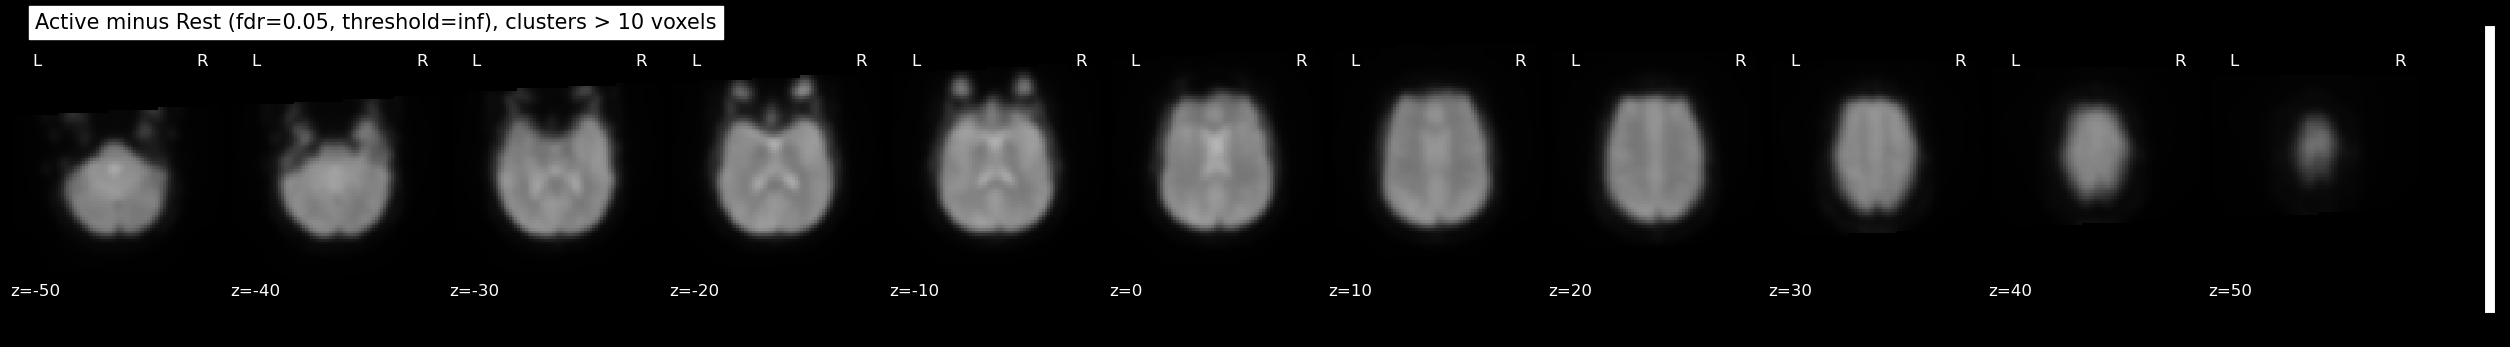

In [19]:

from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()



In [53]:
# Creation of the drift model:
from nilearn.glm.first_level.design_matrix import _make_drift

column_values, column_names = _make_drift(drift_model='polynomial', frame_times= np.arange(0, 525 * 3, 3), order=3, high_pass=None)



In [54]:
design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

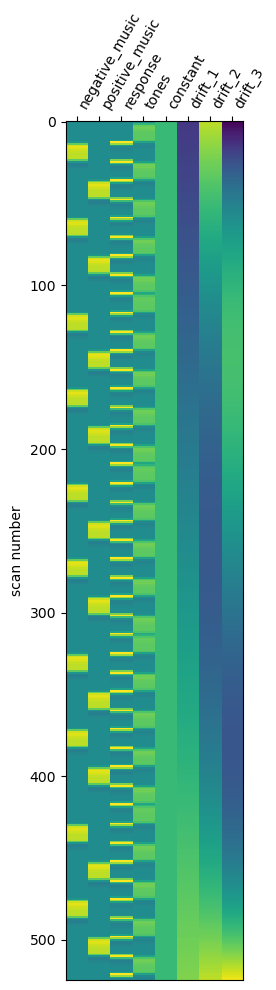

In [55]:

plot_design_matrix(design_mat)
plt.show()



In [56]:
fit_glm = FirstLevelModel(t_r=3.0, drift_model='None')
fit_glm.fit(image, design_matrices=[design_mat])

FirstLevelModel(drift_model='None', t_r=3.0)

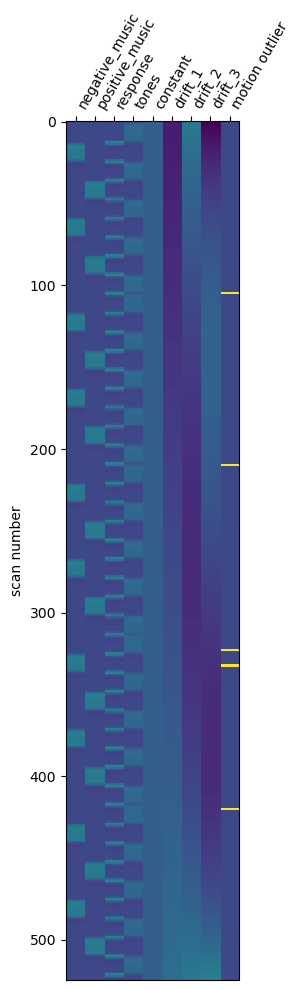

In [59]:

outliers_volumes = np.array([ 105, 210, 323, 332, 333, 420])
reg = np.zeros((525))
#reg[::10] = 1
for idx in outliers_volumes:
    reg[idx] = 1

design_mat_regged = design_mat.copy()
design_mat_regged['motion outlier'] = reg

plot_design_matrix(design_mat_regged)
plt.show()

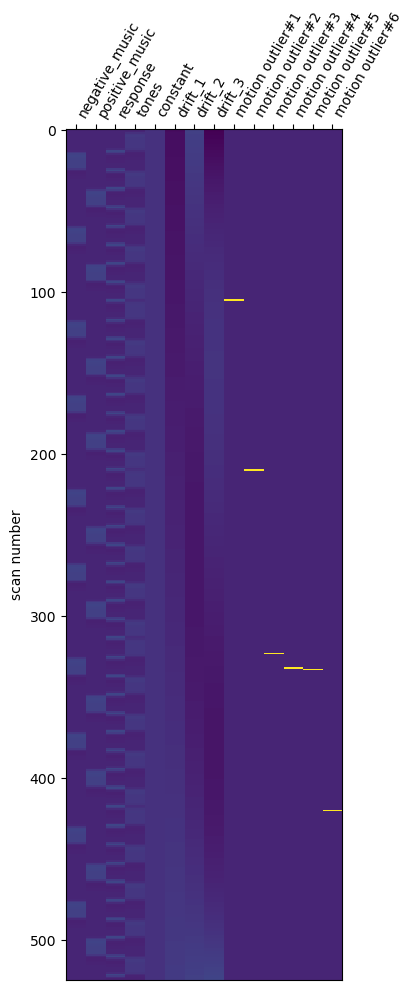

In [60]:
design_mat_regged = design_mat.copy()

for i, idx in enumerate(outliers_volumes):
    reg = np.zeros((525,))
    reg[idx] = 1.0 
    design_mat_regged[f'motion outlier#{i + 1}'] = reg

plot_design_matrix(design_mat_regged)
plt.show()

In [63]:
fit_glm_reg = FirstLevelModel(t_r=3.0, drift_model='None')
fit_glm_reg.fit(image, design_matrices=[design_mat_regged])


FirstLevelModel(drift_model='None', t_r=3.0)

In [64]:
#### REDEFINIR LES VECTORS ? 

import numpy as np

conditions_reg = {
    'negative': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'positive':np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),

}

# SET THRESHOLD FOR ALL THE FOLLOWING STATISTICAL MAPS
set_threshold = 2

positive_minus_negative_reg = conditions_reg['positive'] - conditions_reg['negative']
positive_minus_negative_reg


array([-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

<Axes: label='conditions'>

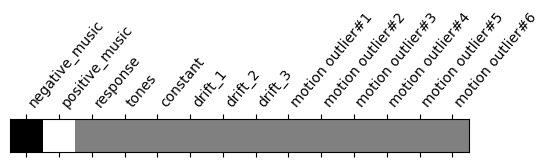

In [68]:
#### Statistical map for POSITIVE AGAINST NEGATIVE for REGS?

import nibabel as nib
z_map_soustraction_regs = fit_glm_reg.compute_contrast(positive_minus_negative_reg,
                                  output_type='z_score')

nib.save(z_map, 'z_map_soustraction_regs_uncorrected.nii.gz')

plot_contrast_matrix(positive_minus_negative_reg, design_matrix=fit_glm_reg.design_matrices_[0])  


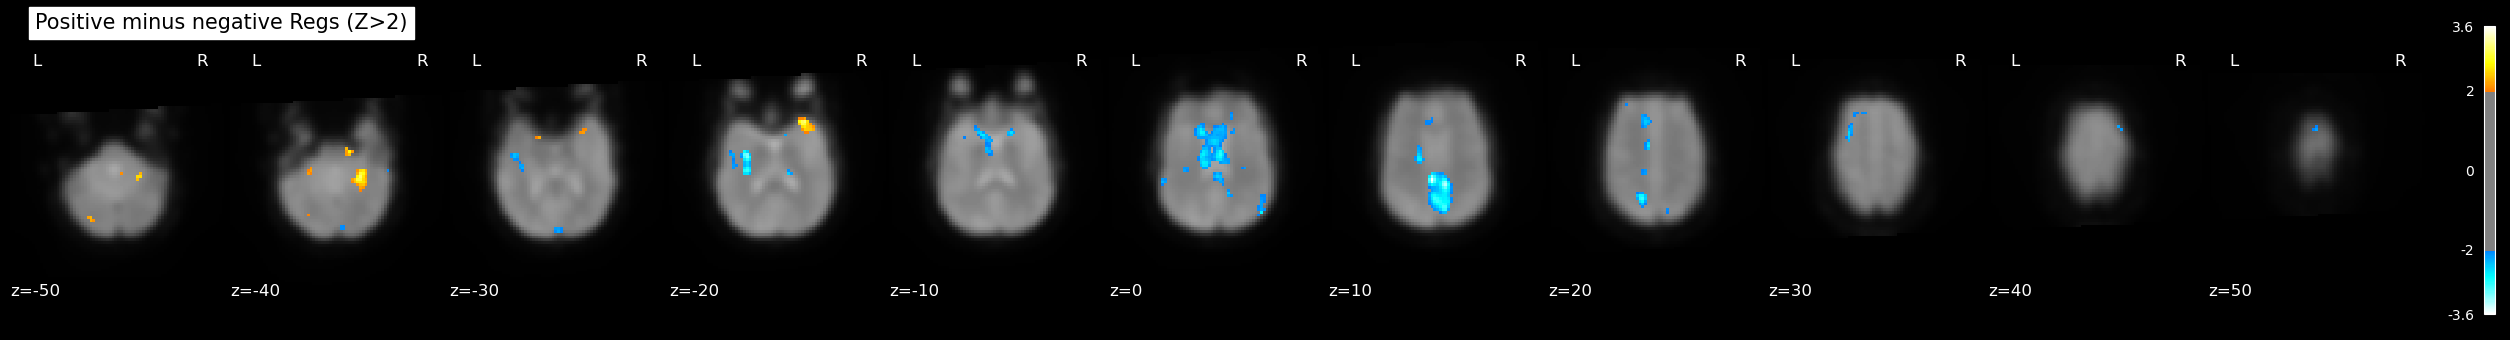

In [70]:

from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(image), # est ce que ça pourrait engendrer des trucs ici ?
plot_stat_map(z_map_soustraction_regs, bg_img=mean_img_[0], threshold=set_threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Positive minus negative Regs (Z>{set_threshold})')
plt.savefig('images_rapport/p_minus_n_regs.png', format='png', dpi =300)
plt.show()